In [3]:
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

from sklearn.metrics import *
from skimage.util.shape import view_as_windows
from sklearn.linear_model import LinearRegression

from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, ConvLSTM2D, LSTM, BatchNormalization, Flatten

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout

# Cropping Images

In [4]:
def crop_images(dataset_path, new_dataset_path, grayscale_path):
    for img_path in dataset_path.glob('*.gif'):    
        try:
            img_name = str(img_path).split("\\")[-1] #get name for image
            image = Image.open(img_path) 
            gray_image = Image.open(img_path).convert("LA") #converts image to grayscale
            image2 = image.crop((43, 23, 400, 267)) #cropping image
            gray_image2 = gray_image.crop((43, 23, 400, 267))
            image2.save(new_dataset_path / img_name)
            gray_image2.save(grayscale_path /img_name) 
            
        except FileNotFoundError:
            pass

images_path = Path(r'D:\Preprocessing\Data')
cropped_images_path = Path(r'D:\Preprocessing\cropped_images')
grayscale_images_path = Path(r'D:\Preprocessing\grayscale')
#crop_images(images_path, cropped_images_path, grayscale_images_path)

In [5]:
X_grayscale = []

def create_grayscale_dataset(path):
    for img_path in path.glob('*.gif'):
        grayscale_image = image.load_img(img_path, color_mode='grayscale', target_size=(100, 100))
        grayscale_image = image.img_to_array(grayscale_image)
        grayscale_image = grayscale_image.reshape(grayscale_image.shape[0], grayscale_image.shape[1])
        X_grayscale.append(grayscale_image)
        
grayscale_images_path = Path(r'D:\Preprocessing\grayscale')
create_grayscale_dataset(grayscale_images_path)

In [6]:
X_grayscale = np.array(X_grayscale)
X_grayscale.shape

(2834, 100, 100)

In [7]:
X_grayscale[0].shape

(100, 100)

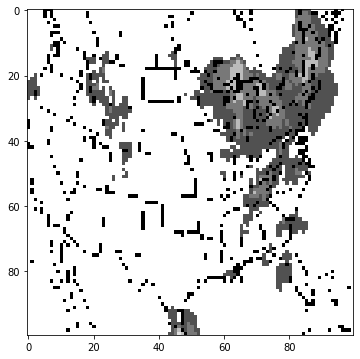

In [8]:
plt.figure(figsize=(8, 6))
plt.imshow(X_grayscale[0], cmap='gray')
plt.show()

# Replacing the values with the appropriate colorbar values

In [7]:
replace_dict = {0.0: 0.00, 29.0: 6.00, 57.0: 4.00, 61.0: 3.00, 81: 0.01, 96: 5.00, 108.0: 2.00, 120: 0.10, 122: 8.00, 150.0: 1.50,
                166.0: 10.00, 187.0: 0.25, 199.0: 12.00, 202.0: 1.00, 210.0: 0.75, 225.0: 0.50, 255.0: 0.00}
#value_coordinates = []
def colorbar_value_replacement():
    for index in range(X_grayscale.shape[0]):
        for row  in range(X_grayscale.shape[1]):
            for column in range(X_grayscale.shape[2]):
                X_grayscale[index][row][column] = replace_dict.get(X_grayscale[index][row][column], X_grayscale[index][row][column])
                

In [8]:
colorbar_value_replacement()

In [9]:
#colorbar_images_path = Path(r'D:\BSc (Hons) Computer Sciences\2020\Honours Project\My Work\Methodology\Preprocessing\colorbar images')

def save_colorbar_images(path):
    counter = 1
    for colorbar_image in X_grayscale:
        img_name = str(counter)+'.gif' #get name for image
        colorbar_image = np.reshape(colorbar_image, (colorbar_image.shape[0], colorbar_image.shape[1], 1))
        colorbar_image = image.array_to_img(colorbar_image)
        colorbar_image.save(path/img_name)
        counter+=1

#save_colorbar_images(colorbar_images_path)

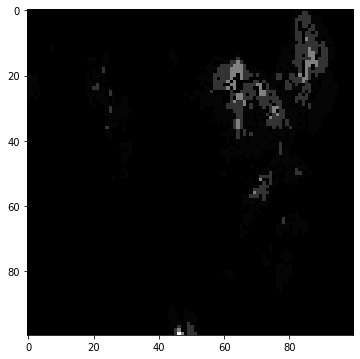

In [10]:
plt.figure(figsize=(8, 6))
plt.imshow(X_grayscale[0], cmap='gray')
plt.show()

In [11]:
def flatten(array):
    result = []
    for row in range(array.shape[0]):
        for col in range(array.shape[0]):
            result.append(array[row][col][1][1]) #remove [1][1] when including neighborhoods
    return result

In [12]:
def flatten_neighborhood(array):
    result = []
    for row in range(array.shape[0]):
        for col in range(array.shape[0]):
            result.append(array[row][col]) 
    return result

In [13]:
def gettingSequenceNeighborhoods(sequence_length, days_ahead, neighborhood_size=(3, 3)):
    
    Y=[]
    dataX = []
    
    for num in range(X_grayscale.shape[0]-(sequence_length + days_ahead) +1):
        X=[]
        for i in range(sequence_length+days_ahead):
            if (i < sequence_length):

                A = np.pad(X_grayscale[i+num], 1, mode='constant')
                neighborhoods = view_as_windows(A, neighborhood_size)
                pixel_intensities = flatten_neighborhood(neighborhoods)
                X.append(pixel_intensities)
                
            elif (i == (sequence_length+days_ahead-1)):
                Y.append(X_grayscale[i+num].flatten())
                
            if (i == sequence_length-1):        
                dataX.append(X)
                
    return dataX, Y

In [14]:
def gettingSequence(sequence_length, days_ahead):
    
    Y=[]
    dataX = []
    
    for num in range(X_grayscale.shape[0]-(sequence_length + days_ahead) +1):
        X=[]
        
        for i in range(sequence_length+days_ahead):
            if (i < sequence_length):

                A = np.pad(X_grayscale[i+num], 1, mode='constant')
                neighborhoods = view_as_windows(A, (3, 3))
                pixel_intensities = flatten(neighborhoods)
                X.append(pixel_intensities)
                
            elif (i == (sequence_length+days_ahead-1)):
                Y.append(X_grayscale[i+num].flatten())
                
            if (i == sequence_length-1):        
                dataX.append(X)        
    return dataX, Y

In [15]:
def gettingSequence_ConvLSTM(sequence_length, days_ahead):
    Y=[]
    dataX = []
    
    for num in range(X_grayscale.shape[0]-(sequence_length + days_ahead) +1):
        X=[]
        for i in range(sequence_length+days_ahead):
            if (i < sequence_length):

                X.append(X_grayscale[i+num])
                
            elif (i == (sequence_length+days_ahead-1)):
                Y.append(X_grayscale[i+num].flatten())
                
            if (i == sequence_length-1):        
                dataX.append(X)
                
    return dataX, Y

In [16]:
def gettingAccumulatedSequence_ConvLSTM(sequence_length, days_ahead):
    Y=[]
    dataX = []
    
    for num in range(X_grayscale.shape[0]-(sequence_length + days_ahead) +1):
        X=[]
        for i in range(sequence_length+days_ahead):
            if (i < sequence_length):
                
                X.append(X_grayscale[i+num])
                
            elif (i == (sequence_length+days_ahead-1)):
                Y.append(X_grayscale[i+num].flatten())
                
            if (i == sequence_length-1):        
                dataX.append(X)
                
    return dataX, Y

In [17]:
def create_training_dataset(X_seq, GT):
    X1 = []
    Y = []
    for sample_no in range(X_seq.shape[0]):
        for pixel_index in range(X_seq.shape[2]):
            x = []
            for sequence_index in range(X_seq.shape[1]):
                x.append(X_seq[sample_no][sequence_index][pixel_index])
            X1.append(x)
        
    return X1, GT.flatten()

In [18]:
def create_daily_training_dataset(X_seq, GT):
    X1 = []
    Y = []
    for sample_no in range(X_seq.shape[0]):
        for pixel_index in range(X_seq.shape[2]):
            x = []
            for sequence_index in range(X_seq.shape[1]):
                x.append(X_seq[sample_no][sequence_index][pixel_index])
            X1.append(x)
        
    return X1, GT.flatten()

In [19]:
def create_accumulated_training_dataset(X_seq, GT):
    X1 = []
    Y = []
    for sample_no in range(X_seq.shape[0]):
        for pixel_index in range(X_seq.shape[2]):
            result = 0
            x = []
            for sequence_index in range(X_seq.shape[1]):
                pixel = X_seq[sample_no][sequence_index][pixel_index]
                result = result + pixel
                x.append(result)
            X1.append(x)
        
    return X1, GT.flatten()

In [20]:
def compare_images(pred, test_Y, num_images):

    y = []
    pred_images = []
    index=0
    for counter in range(num_images):
        pixel_count = 0
        while pixel_count < 10000:
            y.append(pred[index])
            pixel_count+=1
            index+=1
        pred_images.append(np.array(y).reshape(100, 100))
        y=[]

    y = []
    test_images = []
    index=0
    for counter in range(num_images):
        pixel_count = 0
        while pixel_count < 10000:
            y.append(test_Y[index])
            pixel_count+=1
            index+=1
        test_images.append(np.array(y).reshape(100, 100))
        y=[]
    
    pics_per_row = 2
    plt.figure(figsize=(pics_per_row*3.5, num_images*3.5))
        
    for i in range(num_images):
        plt.subplot(num_images,pics_per_row,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        #if (i%2)==0:
        plt.imshow(test_images[i], cmap='gray')
        plt.xlabel("Test Image")
        #else:
        plt.imshow(pred_images[i], cmap='gray')
        plt.xlabel("Prediction Image")
    plt.show()

In [21]:
def last_pixel(array, seq_length, length):
    result = []
    for i in range(length):
        result.append(array[i][seq_length-1])
    return result

In [22]:
def last_frame_regressor(sequence_length, days_ahead):
    X_sequences, ground_truth = gettingSequence(sequence_length, days_ahead)
    X_sequences = np.array(X_sequences)
    ground_truth = np.array(ground_truth)

    X_sequences_test = X_sequences[2557:]
    ground_truth_test = ground_truth[2557:]

    test_X, test_Y = create_training_dataset(X_sequences_test, ground_truth_test)
    
    test_X_last_pixel = last_pixel(test_X, sequence_length, len(test_X))
    test_X_last_pixel = np.array(test_X_last_pixel)
    mae_untrained = mean_absolute_error(test_Y, test_X_last_pixel)
    rmse_untrained = math.sqrt(mean_squared_error(test_Y, test_X_last_pixel))
    print("Sequence Length {} | Days Ahead {}".format(sequence_length, days_ahead))
    print("mae untrained: ", mae_untrained)
    print("rmse untrained: ", rmse_untrained)
    

In [23]:
def multivariate_data(sequence_length, days_ahead):
    X_sequences, ground_truth = gettingSequence(sequence_length, days_ahead)
    X_sequences = np.array(X_sequences)
    ground_truth = np.array(ground_truth)
    
    X_sequences_train = X_sequences[2557-730:2557]
    ground_truth_train = ground_truth[2557-730:2557]
    X_sequences_test = X_sequences[2557:]
    ground_truth_test = ground_truth[2557:]
    
    train_X, train_Y = create_training_dataset(X_sequences_train, ground_truth_train)
    test_X, test_Y = create_training_dataset(X_sequences_test, ground_truth_test)
    
    
    return train_X, train_Y, test_X, test_Y

In [24]:
def convlstm_data(sequence_length, days_ahead):
    X_sequences, ground_truth = gettingSequence_ConvLSTM(sequence_length, days_ahead)
    X_sequences = np.array(X_sequences)
    ground_truth = np.array(ground_truth)

    train_X = X_sequences[:2192]
    train_Y = ground_truth[:2192]
    val_X = X_sequences[2192:2557]
    val_Y = ground_truth[2192:2557]
    test_X = X_sequences[2557:]
    test_Y = ground_truth[2557:]

    train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1, train_X.shape[2], train_X.shape[3]))
    val_X = np.reshape(val_X, (val_X.shape[0], val_X.shape[1], 1, val_X.shape[2], val_X.shape[3]))
    test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1, test_X.shape[2], test_X.shape[3]))
    
    return train_X, train_Y, val_X, val_Y, test_X, test_Y

# Last Frame Regressor

### Sequence Length = 4

#### 1 Day Ahead

In [30]:
last_frame_regressor(4, 1)

Sequence Length 4 | Days Ahead 1
mae untrained:  0.057908997
rmse untrained:  0.1959540986904649


#### 2 Days Ahead

In [36]:
last_frame_regressor(4, 2)

Sequence Length 4 | Days Ahead 2
mae untrained:  0.06502372
rmse untrained:  0.2113608509468191


#### 4 Days Ahead

In [37]:
last_frame_regressor(4, 4)

Sequence Length 4 | Days Ahead 4
mae untrained:  0.065349646
rmse untrained:  0.21117821839486867


#### 7 Days Ahead

In [38]:
last_frame_regressor(4, 7)

Sequence Length 4 | Days Ahead 7
mae untrained:  0.06540832
rmse untrained:  0.21171405688500158


#### 12 Days Ahead

In [39]:
last_frame_regressor(4, 12)

Sequence Length 4 | Days Ahead 12
mae untrained:  0.06658082
rmse untrained:  0.21497971827189832


### Sequence Length = 8

#### 1 Day Ahead

In [24]:
last_frame_regressor(8, 1)

Sequence Length 8 | Days Ahead 1
mae untrained:  0.05796505
rmse untrained:  0.19627058596977234


#### 2 Days Ahead

In [25]:
last_frame_regressor(8, 2)

Sequence Length 8 | Days Ahead 2
mae untrained:  0.065069444
rmse untrained:  0.21173985084027233


#### 4 Days Ahead

In [26]:
last_frame_regressor(8, 4)

Sequence Length 8 | Days Ahead 4
mae untrained:  0.06560334
rmse untrained:  0.21174425801966934


#### 7 Days Ahead

In [27]:
last_frame_regressor(8, 7)

Sequence Length 8 | Days Ahead 7
mae untrained:  0.06547968
rmse untrained:  0.21206172948933963


#### 12 Days Ahead

In [28]:
last_frame_regressor(8, 12)

Sequence Length 8 | Days Ahead 12
mae untrained:  0.066585965
rmse untrained:  0.2150256254067322


### Sequence Length = 12

#### 1 Day Ahead

In [29]:
last_frame_regressor(12, 1)

Sequence Length 12 | Days Ahead 1
mae untrained:  0.058383726
rmse untrained:  0.19722224221169754


#### 2 Days Ahead

In [30]:
last_frame_regressor(12, 2)

Sequence Length 12 | Days Ahead 2
mae untrained:  0.065471
rmse untrained:  0.21272385040597525


#### 4 Days Ahead

In [24]:
last_frame_regressor(12, 4)

Sequence Length 12 | Days Ahead 4
mae untrained:  0.06602443
rmse untrained:  0.21277016547726468


#### 7 Days Ahead

In [25]:
last_frame_regressor(12, 7)

Sequence Length 12 | Days Ahead 7
mae untrained:  0.065920375
rmse untrained:  0.21303608500872415


#### 12 Days Ahead

In [26]:
last_frame_regressor(12, 12)

Sequence Length 12 | Days Ahead 12
mae untrained:  0.06677704
rmse untrained:  0.21552109149667265


# Linear Regressor

### Sequence Length = 4

#### 1 Day Ahead

In [34]:
train_X, train_Y, test_X, test_Y = multivariate_data(4, 1) 
multivariate_regressor = LinearRegression()
multivariate_regressor.fit(train_X, train_Y)
y_pred = multivariate_regressor.predict(test_X)

mae_trained = mean_absolute_error(test_Y, y_pred)
rmse_trained = math.sqrt(mean_squared_error(test_Y, y_pred))
print("Sequence Length {} | Days Ahead {}".format(4, 1))
print("mae trained: ", mae_trained)
print("rmse trained: ", rmse_trained)

Sequence Length 4 | Days Ahead 1
mae trained:  0.059399948
rmse trained:  0.15252955427831327


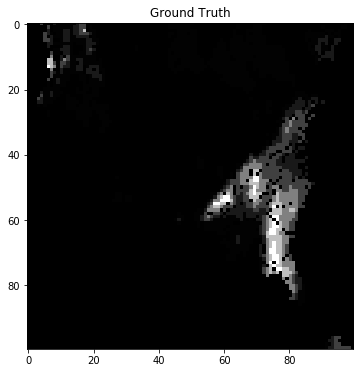

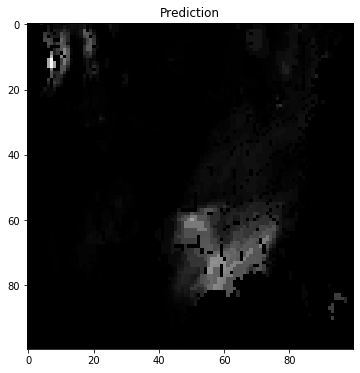

In [35]:
a = test_Y[:10000]
b = y_pred[:10000]
a = np.reshape(a, (100, 100))
b = np.reshape(b, (100, 100))

plt.figure(figsize=(8, 6))
plt.imshow(a, cmap='gray')
plt.title("Ground Truth")
plt.savefig("ground_truth_4_1")
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(b, cmap='gray')
plt.title("Prediction")
plt.savefig("multivariate_regressor_4_1")
plt.show()

#### 2 Days Ahead

In [36]:
train_X, train_Y, test_X, test_Y = multivariate_data(4, 2) 
multivariate_regressor = LinearRegression()
multivariate_regressor.fit(train_X, train_Y)
y_pred = multivariate_regressor.predict(test_X)

mae_trained = mean_absolute_error(test_Y, y_pred)
rmse_trained = math.sqrt(mean_squared_error(test_Y, y_pred))
print("Sequence Length {} | Days Ahead {}".format(4, 2))
print("mae trained: ", mae_trained)
print("rmse trained: ", rmse_trained)

Sequence Length 4 | Days Ahead 2
mae trained:  0.062034063
rmse trained:  0.15560213122996763


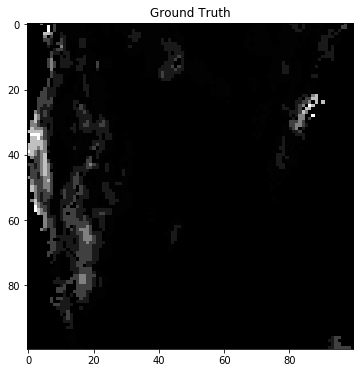

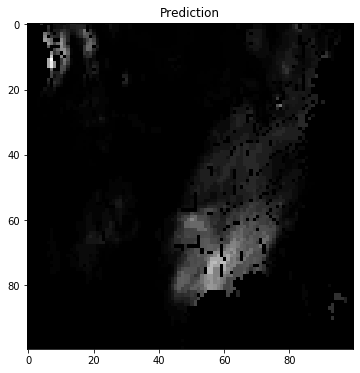

In [37]:
a = test_Y[:10000]
b = y_pred[:10000]
a = np.reshape(a, (100, 100))
b = np.reshape(b, (100, 100))

plt.figure(figsize=(8, 6))
plt.imshow(a, cmap='gray')
plt.title("Ground Truth")
plt.savefig("ground_truth_4_2")
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(b, cmap='gray')
plt.title("Prediction")
plt.savefig("multivariate_regressor_4_2")
plt.show()

#### 4 Days Ahead

In [38]:
train_X, train_Y, test_X, test_Y = multivariate_data(4, 4) 
multivariate_regressor = LinearRegression()
multivariate_regressor.fit(train_X, train_Y)
y_pred = multivariate_regressor.predict(test_X)

mae_trained = mean_absolute_error(test_Y, y_pred)
rmse_trained = math.sqrt(mean_squared_error(test_Y, y_pred))
print("Sequence Length {} | Days Ahead {}".format(4, 4))
print("mae trained: ", mae_trained)
print("rmse trained: ", rmse_trained)

Sequence Length 4 | Days Ahead 4
mae trained:  0.06227257
rmse trained:  0.15593937754217418


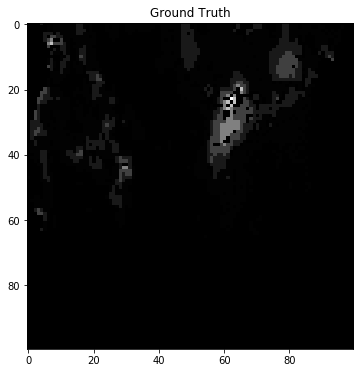

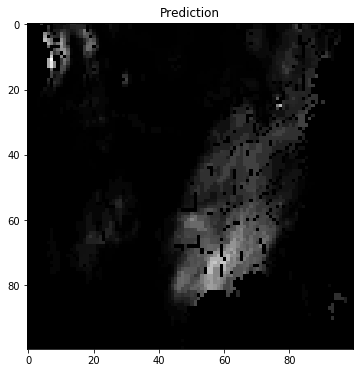

In [39]:
a = test_Y[:10000]
b = y_pred[:10000]
a = np.reshape(a, (100, 100))
b = np.reshape(b, (100, 100))

plt.figure(figsize=(8, 6))
plt.imshow(a, cmap='gray')
plt.title("Ground Truth")
plt.savefig("ground_truth_4_4")
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(b, cmap='gray')
plt.title("Prediction")
plt.savefig("multivariate_regressor_4_4")
plt.show()

#### 7 Days Ahead

In [40]:
train_X, train_Y, test_X, test_Y = multivariate_data(4, 7) 
multivariate_regressor = LinearRegression()
multivariate_regressor.fit(train_X, train_Y)
y_pred = multivariate_regressor.predict(test_X)

mae_trained = mean_absolute_error(test_Y, y_pred)
rmse_trained = math.sqrt(mean_squared_error(test_Y, y_pred))
print("Sequence Length {} | Days Ahead {}".format(4, 7))
print("mae trained: ", mae_trained)
print("rmse trained: ", rmse_trained)

Sequence Length 4 | Days Ahead 7
mae trained:  0.0625071
rmse trained:  0.15683266955779776


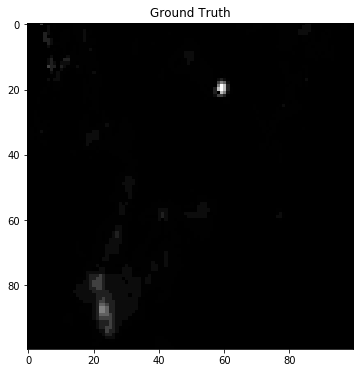

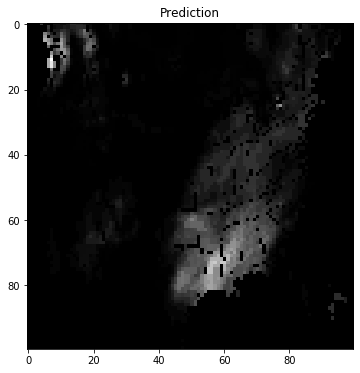

In [41]:
a = test_Y[:10000]
b = y_pred[:10000]
a = np.reshape(a, (100, 100))
b = np.reshape(b, (100, 100))

plt.figure(figsize=(8, 6))
plt.imshow(a, cmap='gray')
plt.title("Ground Truth")
plt.savefig("ground_truth_4_7")
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(b, cmap='gray')
plt.title("Prediction")
plt.savefig("multivariate_regressor_4_7")
plt.show()

#### 12 Days Ahead

In [42]:
train_X, train_Y, test_X, test_Y = multivariate_data(4, 12) 
multivariate_regressor = LinearRegression()
multivariate_regressor.fit(train_X, train_Y)
y_pred = multivariate_regressor.predict(test_X)

mae_trained = mean_absolute_error(test_Y, y_pred)
rmse_trained = math.sqrt(mean_squared_error(test_Y, y_pred))
print("Sequence Length {} | Days Ahead {}".format(4, 12))
print("mae trained: ", mae_trained)
print("rmse trained: ", rmse_trained)

Sequence Length 4 | Days Ahead 12
mae trained:  0.06285989
rmse trained:  0.15806504687704334


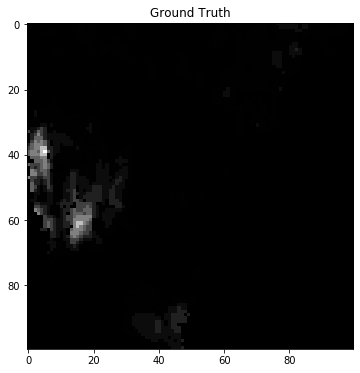

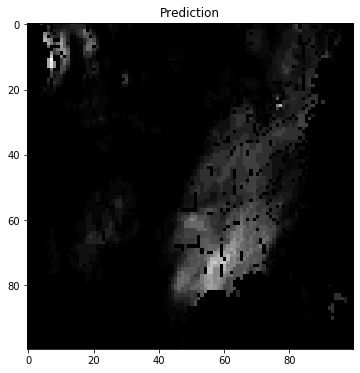

In [43]:
a = test_Y[:10000]
b = y_pred[:10000]
a = np.reshape(a, (100, 100))
b = np.reshape(b, (100, 100))

plt.figure(figsize=(8, 6))
plt.imshow(a, cmap='gray')
plt.title("Ground Truth")
plt.savefig("ground_truth_4_12")
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(b, cmap='gray')
plt.title("Prediction")
plt.savefig("multivariate_regressor_4_12")
plt.show()

### Sequence Length = 8

#### 1 Day Ahead

In [26]:
train_X, train_Y, test_X, test_Y = multivariate_data(8, 1) 
multivariate_regressor = LinearRegression()
multivariate_regressor.fit(train_X, train_Y)
y_pred = multivariate_regressor.predict(test_X)

mae_trained = mean_absolute_error(test_Y, y_pred)
rmse_trained = math.sqrt(mean_squared_error(test_Y, y_pred))
print("Sequence Length {} | Days Ahead {}".format(8, 1))
print("mae trained: ", mae_trained)
print("rmse trained: ", rmse_trained)

Sequence Length 8 | Days Ahead 1
mae trained:  0.058861665
rmse trained:  0.15236032224651555


Sequence Length 8 | Days Ahead 1
mae trained:  0.05888431


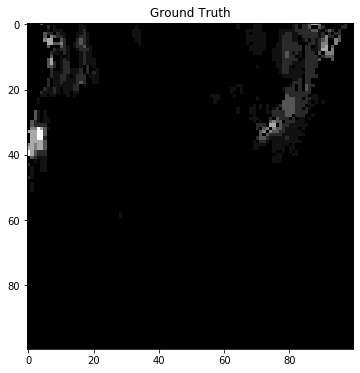

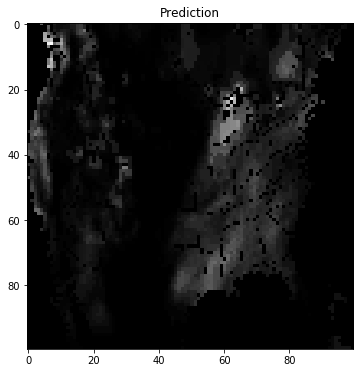

In [34]:
a = test_Y[:10000]
b = y_pred[:10000]
a = np.reshape(a, (100, 100))
b = np.reshape(b, (100, 100))

plt.figure(figsize=(8, 6))
plt.imshow(a, cmap='gray')
plt.title("Ground Truth")
#plt.savefig("ground_truth_8_1")
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(b, cmap='gray')
plt.title("Prediction")
plt.savefig("multivariate_regressor_8_1_less_train_data")
plt.show()

#### 2 Days Ahead

In [35]:
train_X, train_Y, test_X, test_Y = multivariate_data(8, 2) 
multivariate_regressor = LinearRegression()
multivariate_regressor.fit(train_X, train_Y)
y_pred = multivariate_regressor.predict(test_X)

mae_trained = mean_absolute_error(test_Y, y_pred)
rmse_trained = math.sqrt(mean_squared_error(test_Y, y_pred))
print("Sequence Length {} | Days Ahead {}".format(8, 2))
print("mae trained: ", mae_trained)
print("rmse trained: ", rmse_trained)

Sequence Length 8 | Days Ahead 2
mae trained:  0.061622553
rmse trained:  0.15533659508235045


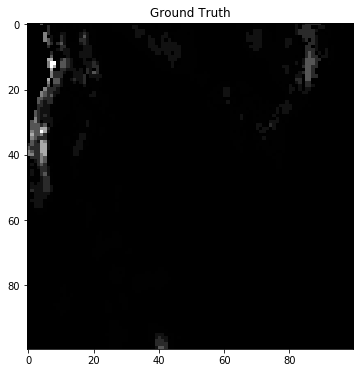

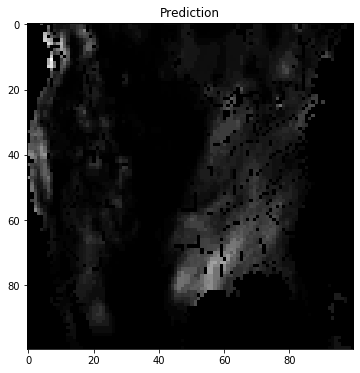

In [36]:
a = test_Y[:10000]
b = y_pred[:10000]
a = np.reshape(a, (100, 100))
b = np.reshape(b, (100, 100))

plt.figure(figsize=(8, 6))
plt.imshow(a, cmap='gray')
plt.title("Ground Truth")
plt.savefig("ground_truth_8_2")
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(b, cmap='gray')
plt.title("Prediction")
plt.savefig("multivariate_regressor_8_2")
plt.show()

#### 4 Days Ahead

In [25]:
train_X, train_Y, test_X, test_Y = multivariate_data(8, 4) 
multivariate_regressor = LinearRegression()
multivariate_regressor.fit(train_X, train_Y)
y_pred = multivariate_regressor.predict(test_X)

mae_trained = mean_absolute_error(test_Y, y_pred)
rmse_trained = math.sqrt(mean_squared_error(test_Y, y_pred))
print("Sequence Length {} | Days Ahead {}".format(8, 4))
print("mae trained: ", mae_trained)
print("rmse trained: ", rmse_trained)

Sequence Length 8 | Days Ahead 4
mae trained:  0.062015813
rmse trained:  0.15590583328754143


In [26]:
y_pred

array([0.02493796, 0.02493796, 0.02493796, ..., 0.13827468, 0.13827468,
       0.02493796], dtype=float32)

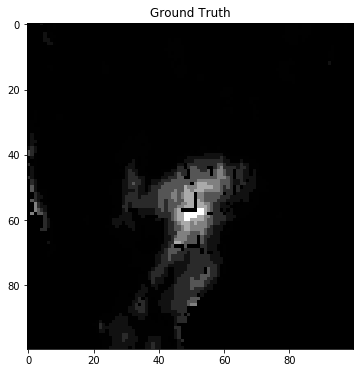

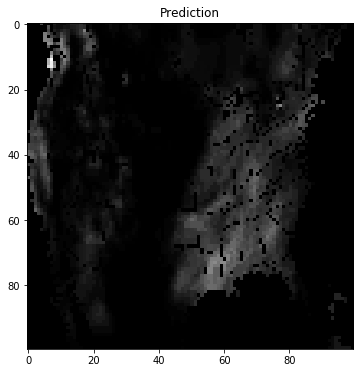

In [27]:
a = test_Y[:10000]
b = y_pred[:10000]
a = np.reshape(a, (100, 100))
b = np.reshape(b, (100, 100))

plt.figure(figsize=(8, 6))
plt.imshow(a, cmap='gray')
plt.title("Ground Truth")
plt.savefig("ground_truth_8_4")
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(b, cmap='gray')
plt.title("Prediction")
plt.savefig("multivariate_regressor_8_4")
plt.show()

#### 7 Days Ahead

In [28]:
train_X, train_Y, test_X, test_Y = multivariate_data(8, 7) 
multivariate_regressor = LinearRegression()
multivariate_regressor.fit(train_X, train_Y)
y_pred = multivariate_regressor.predict(test_X)

mae_trained = mean_absolute_error(test_Y, y_pred)
rmse_trained = math.sqrt(mean_squared_error(test_Y, y_pred))
print("Sequence Length {} | Days Ahead {}".format(8, 7))
print("mae trained: ", mae_trained)
print("rmse trained: ", rmse_trained)

Sequence Length 8 | Days Ahead 7
mae trained:  0.06234561
rmse trained:  0.1566758491979904


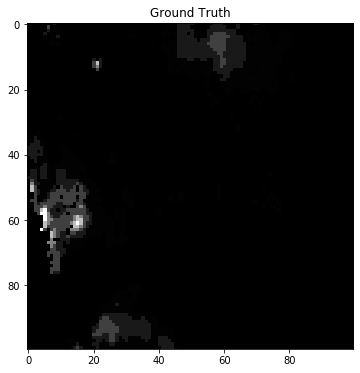

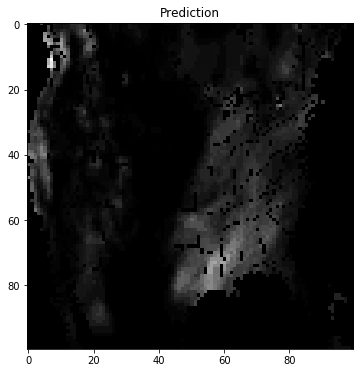

In [29]:
a = test_Y[:10000]
b = y_pred[:10000]
a = np.reshape(a, (100, 100))
b = np.reshape(b, (100, 100))

plt.figure(figsize=(8, 6))
plt.imshow(a, cmap='gray')
plt.title("Ground Truth")
plt.savefig("ground_truth_8_7")
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(b, cmap='gray')
plt.title("Prediction")
plt.savefig("multivariate_regressor_8_7")
plt.show()

#### 12 Days Ahead

In [30]:
train_X, train_Y, test_X, test_Y = multivariate_data(8, 12) 
multivariate_regressor = LinearRegression()
multivariate_regressor.fit(train_X, train_Y)
y_pred = multivariate_regressor.predict(test_X)

mae_trained = mean_absolute_error(test_Y, y_pred)
rmse_trained = math.sqrt(mean_squared_error(test_Y, y_pred))
print("Sequence Length {} | Days Ahead {}".format(8, 12))
print("mae trained: ", mae_trained)
print("rmse trained: ", rmse_trained)

Sequence Length 8 | Days Ahead 12
mae trained:  0.06237092
rmse trained:  0.1571713166883507


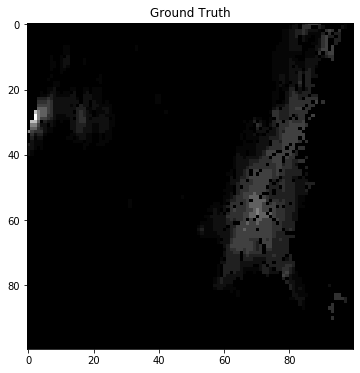

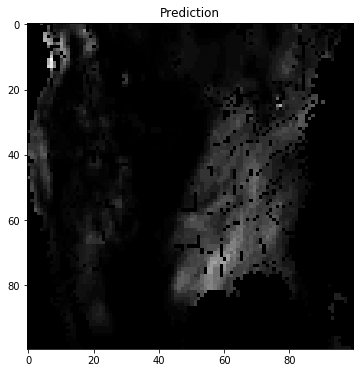

In [31]:
a = test_Y[:10000]
b = y_pred[:10000]
a = np.reshape(a, (100, 100))
b = np.reshape(b, (100, 100))

plt.figure(figsize=(8, 6))
plt.imshow(a, cmap='gray')
plt.title("Ground Truth")
plt.savefig("ground_truth_8_12")
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(b, cmap='gray')
plt.title("Prediction")
plt.savefig("multivariate_regressor_8_12")
plt.show()

### Sequence Length = 12

#### 1 Day Ahead

In [32]:
train_X, train_Y, test_X, test_Y = multivariate_data(12, 1) 
multivariate_regressor = LinearRegression()
multivariate_regressor.fit(train_X, train_Y)
y_pred = multivariate_regressor.predict(test_X)

mae_trained = mean_absolute_error(test_Y, y_pred)
rmse_trained = math.sqrt(mean_squared_error(test_Y, y_pred))
print("Sequence Length {} | Days Ahead {}".format(12, 1))
print("mae trained: ", mae_trained)
print("rmse trained: ", rmse_trained)

Sequence Length 12 | Days Ahead 1
mae trained:  0.058660924
rmse trained:  0.15266337244369702


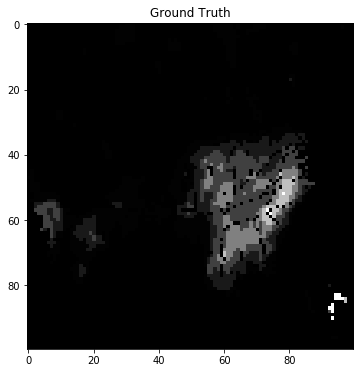

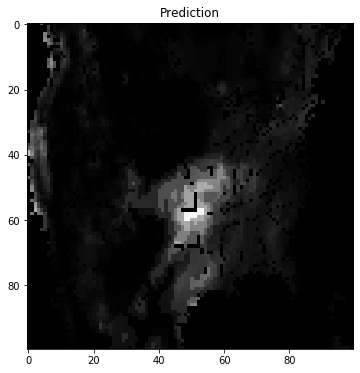

In [33]:
a = test_Y[:10000]
b = y_pred[:10000]
a = np.reshape(a, (100, 100))
b = np.reshape(b, (100, 100))

plt.figure(figsize=(8, 6))
plt.imshow(a, cmap='gray')
plt.title("Ground Truth")
plt.savefig("ground_truth_12_1")
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(b, cmap='gray')
plt.title("Prediction")
plt.savefig("multivariate_regressor_12_1")
plt.show()

#### 2 Days Ahead

In [34]:
train_X, train_Y, test_X, test_Y = multivariate_data(12, 2) 
multivariate_regressor = LinearRegression()
multivariate_regressor.fit(train_X, train_Y)
y_pred = multivariate_regressor.predict(test_X)

mae_trained = mean_absolute_error(test_Y, y_pred)
rmse_trained = math.sqrt(mean_squared_error(test_Y, y_pred))
print("Sequence Length {} | Days Ahead {}".format(12, 2))
print("mae trained: ", mae_trained)
print("rmse trained: ", rmse_trained)

Sequence Length 12 | Days Ahead 2
mae trained:  0.061229836
rmse trained:  0.15545089945080484


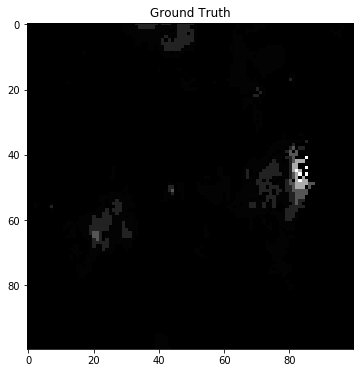

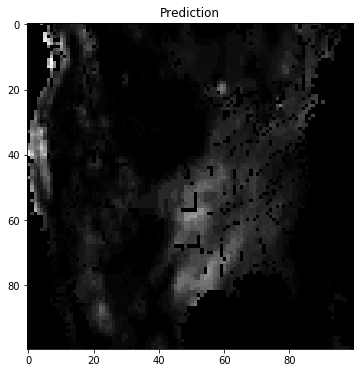

In [35]:
a = test_Y[:10000]
b = y_pred[:10000]
a = np.reshape(a, (100, 100))
b = np.reshape(b, (100, 100))

plt.figure(figsize=(8, 6))
plt.imshow(a, cmap='gray')
plt.title("Ground Truth")
plt.savefig("ground_truth_12_2")
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(b, cmap='gray')
plt.title("Prediction")
plt.savefig("multivariate_regressor_12_2")
plt.show()

#### 4 Days Ahead

In [36]:
train_X, train_Y, test_X, test_Y = multivariate_data(12, 4) 
multivariate_regressor = LinearRegression()
multivariate_regressor.fit(train_X, train_Y)
y_pred = multivariate_regressor.predict(test_X)

mae_trained = mean_absolute_error(test_Y, y_pred)
rmse_trained = math.sqrt(mean_squared_error(test_Y, y_pred))
print("Sequence Length {} | Days Ahead {}".format(12, 4))
print("mae trained: ", mae_trained)
print("rmse trained: ", rmse_trained)

Sequence Length 12 | Days Ahead 4
mae trained:  0.06162729
rmse trained:  0.1561807240454658


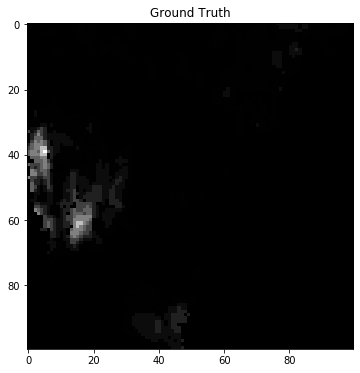

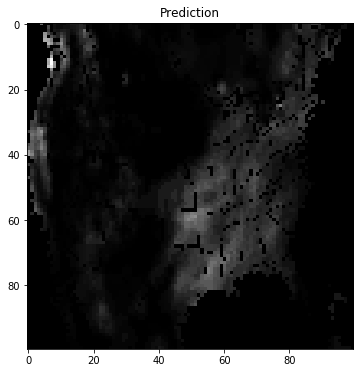

In [37]:
a = test_Y[:10000]
b = y_pred[:10000]
a = np.reshape(a, (100, 100))
b = np.reshape(b, (100, 100))

plt.figure(figsize=(8, 6))
plt.imshow(a, cmap='gray')
plt.title("Ground Truth")
plt.savefig("ground_truth_12_4")
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(b, cmap='gray')
plt.title("Prediction")
plt.savefig("multivariate_regressor_12_4")
plt.show()

#### 7 Days Ahead

In [38]:
train_X, train_Y, test_X, test_Y = multivariate_data(12, 7) 
multivariate_regressor = LinearRegression()
multivariate_regressor.fit(train_X, train_Y)
y_pred = multivariate_regressor.predict(test_X)

mae_trained = mean_absolute_error(test_Y, y_pred)
rmse_trained = math.sqrt(mean_squared_error(test_Y, y_pred))
print("Sequence Length {} | Days Ahead {}".format(12, 7))
print("mae trained: ", mae_trained)
print("rmse trained: ", rmse_trained)

Sequence Length 12 | Days Ahead 7
mae trained:  0.06165973
rmse trained:  0.15646362602303823


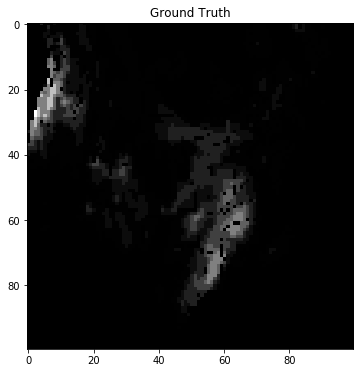

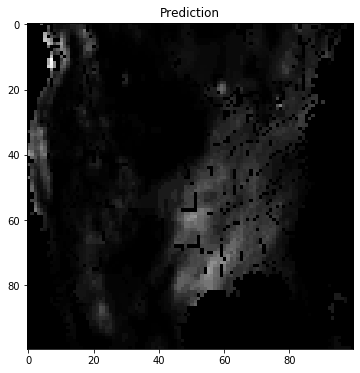

In [39]:
a = test_Y[:10000]
b = y_pred[:10000]
a = np.reshape(a, (100, 100))
b = np.reshape(b, (100, 100))

plt.figure(figsize=(8, 6))
plt.imshow(a, cmap='gray')
plt.title("Ground Truth")
plt.savefig("ground_truth_12_7")
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(b, cmap='gray')
plt.title("Prediction")
plt.savefig("multivariate_regressor_12_7")
plt.show()

#### 12 Days Ahead

In [40]:
train_X, train_Y, test_X, test_Y = multivariate_data(12, 12) 
multivariate_regressor = LinearRegression()
multivariate_regressor.fit(train_X, train_Y)
y_pred = multivariate_regressor.predict(test_X)

mae_trained = mean_absolute_error(test_Y, y_pred)
rmse_trained = math.sqrt(mean_squared_error(test_Y, y_pred))
print("Sequence Length {} | Days Ahead {}".format(12, 12))
print("mae trained: ", mae_trained)
print("rmse trained: ", rmse_trained)

Sequence Length 12 | Days Ahead 12
mae trained:  0.061686754
rmse trained:  0.15655285571425992


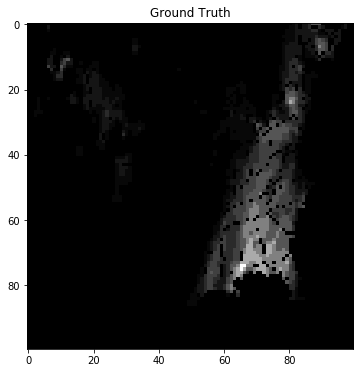

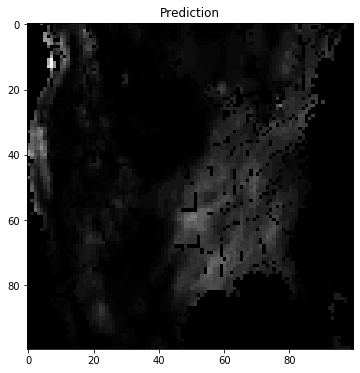

In [41]:
a = test_Y[:10000]
b = y_pred[:10000]
a = np.reshape(a, (100, 100))
b = np.reshape(b, (100, 100))

plt.figure(figsize=(8, 6))
plt.imshow(a, cmap='gray')
plt.title("Ground Truth")
plt.savefig("ground_truth_12_12")
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(b, cmap='gray')
plt.title("Prediction")
plt.savefig("multivariate_regressor_12_12")
plt.show()